<a href="https://colab.research.google.com/github/dsliwka/EEMP2023/blob/main/SalesSimSampleSolutionsWithComments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from statsmodels.iolib.summary2 import summary_col
!pip install Stargazer
from stargazer.stargazer import Stargazer
import matplotlib.pyplot as plt

**Exercise I: Simulate Training**

----



In [40]:
n=500
df=pd.DataFrame(index=range(n))
df['ability']=np.random.normal(100,15,n)
df['training']=(df.ability+ np.random.normal(0,10,n)>=100)*1
df['sales']=40000+df.training*5000+df.ability*100+np.random.normal(0,4000,n)
df.drop(columns=['ability'])

,training,sales
0,0,45926.836817
1,1,49490.860550
2,0,45212.084944
3,0,46489.011604
4,1,54886.421695
...,...,...
495,0,46283.871757
496,0,50382.072832
497,1,57277.755642
498,1,45306.646993


In [41]:
df.groupby(df.training).sales.mean()

training
0    48536.364858
1    56014.874893
Name: sales, dtype: float64

(45000.0, 60000.0)

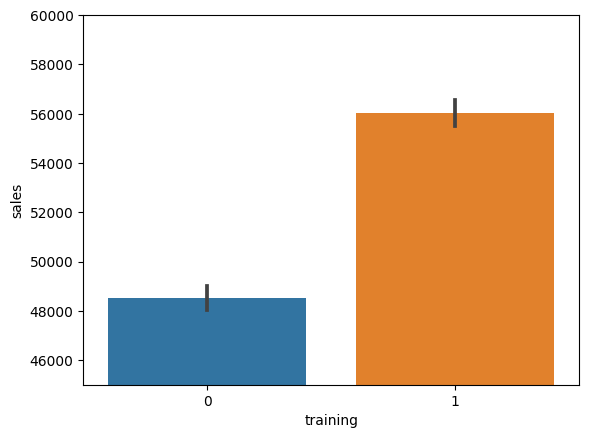

In [42]:
sns.barplot(x="training", y="sales", data=df)

plt.ylim(45000, 60000)

**Interpretation**

Trained employees on average have about 7.000 Euro higher sales.
Note: We should not interpret this as a causal effect of the treatment as the mean difference is the sum of the causal effect of the treatment on the treated plus the selection bias. An analyist that has only data on training and sales cannot disentangle these two components.

In [43]:
reg=smf.ols('sales ~ training', data=df).fit()
Stargazer([reg])

**Exercise II: Simulate RCT**

----


In [44]:
n=50000
df=pd.DataFrame(index=range(n))
df['ability']=np.random.normal(100,15,n)
df['training']=(df.ability+ np.random.normal(0,10,n)>=100)*1
df['sales']=40000+df.training*5000+df.ability*100+np.random.normal(0,4000,n)
df.drop(columns=['ability'])

## Now: Training2 randomly assigned
df['training2']=np.random.binomial(1, 0.05, n)
df['sales']= df.sales + df.training2*5000




In [45]:
df.groupby(df.training2).sales.mean()

training2
0    52476.864822
1    57350.656676
Name: sales, dtype: float64

(45000.0, 65000.0)

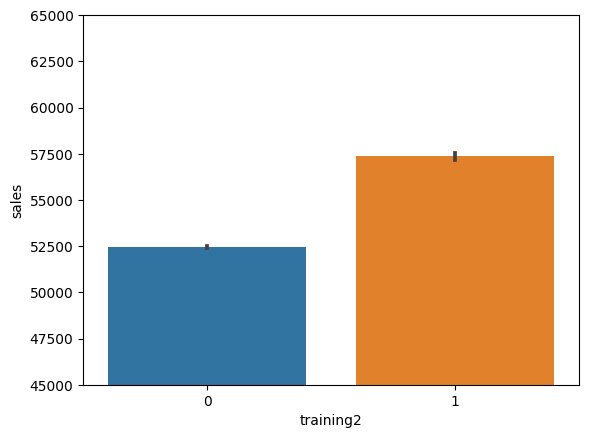

In [46]:
sns.barplot(x="training2", y="sales", data=df)
plt.ylim(45000, 65000)

In [47]:
reg=smf.ols('sales ~ training + training2', data=df).fit()
Stargazer([reg])

**Interpretation**

The fact that training is now randomly assigned eliminates the selection bias (as the counterfactual outcomes cannot systematically differ when there is random assignment). In a large enough sample we get closer and closer to the true causal effect.


**Exercise III: Control Variables & OVB**

----


In [48]:
n=500000
df=pd.DataFrame(index=range(n))
df['ability']=np.random.normal(100,15,n)
df['training']=(df.ability+ np.random.normal(0,10,n)>=100)*1
df['sales']=40000+df.training*5000+df.ability*100+np.random.normal(0,4000,n)

regShort=smf.ols('sales ~ training ', data=df).fit()
regLong=smf.ols('sales ~ training + ability', data=df).fit()
Stargazer([regShort,regLong])

**Interpretation**

By controlling for ability we elimiate the selection bias (or equivalently the omitted variable bias). This works here quite well, because the CIA holds: The training is randomly assigned conditional on ability (i.e. two subjects of the same ability have the same likelihood to be trained).

Note: In real world application we can of course be not entirely sure that this is the case. But we can still check variables that are candidated for causing OVB. When we control for these variables and the coefficient of interest (here of training) does not change very much, we can argue that the variable likely does not cause OVB.

In [49]:
regA=smf.ols('ability ~ training', data=df).fit()
Stargazer([regA])

**Interpretation**

Now we decompose the OVB using the OVB formula. To do so, we here estimate the ability difference between trained and untrained workers (Note: This is not causal, it is just the difference in conditional expectations). This ability difference is given by the coefficient of training in the above regression (your estimate should be somewhere near 20). That is trained workers have a roughly 20 points higher ability.  
Then we multiply this ability difference with the coefficient of ability we take from the regression above of sales on training and ability (the "long regression").


In [50]:
print("The OVB is", regA.params[1]*regLong.params[2])
print("The reason is that we estimate that trained subjects have a ",regA.params[1], "points higher ability.")
print("and each point of ability is predicted to yield", regLong.params[2], "more sales."  )

The OVB is 1982.9474796361862
The reason is that we estimate that trained subjects have a  19.939199514291438 points higher ability.
and each point of ability is predicted to yield 99.4497034956146 more sales.


**Interpretation**
Note that this is exactly the difference between the training coefficient in the short and the long regression above.

In [51]:
print("The OVB is also equal to", regShort.params[1]-regLong.params[1])

The OVB is also equal to 1982.9474796361192


**Exercise IV: Purposes of Control Variables**

----


In [52]:
n=500
df=pd.DataFrame(index=range(n))
df['ability']=np.random.normal(100,15,n)
df['experience']=np.random.uniform(0,30,n)
df['training']=(df.ability+ np.random.normal(0,10,n)>100)*1
df['sales']=10000+df.training*5000+df.ability*100+df.experience*15000+np.random.normal(0,4000,n)

In [53]:
reg1=smf.ols('sales ~ training', data=df).fit()
reg2=smf.ols('sales ~ training + experience', data=df).fit()
reg3=smf.ols('sales ~ training + ability', data=df).fit()
reg4=smf.ols('sales ~ training + ability + experience', data=df).fit()
tab=Stargazer([reg1,reg2,reg3,reg4])
tab.covariate_order(["training", "ability", "experience"])
tab

**Interpretation**

Here controlling for experience and ability is useful. They both help us to get better estimates of the causal effect.

In fact (as the simulated data is set up) here they serve two different purposes:

Ability here again causes an OVB & controlling for it eliminates this issue. In a large enough sample (try different values for n in the simulation!) it should suffice to control for ability to have good estimate of the causal effect as there are no other variables causing OVB here.

Still in the small sample we have, estimates are very noisy (standard errors are large). Here controlling for experience helps as it has a very strong impact on sales. Controlling for it reduces the standard errors substantially. When we only control for experience we have rather precise estimates of the association between training and sales - but will still be biased as the OVB is only eliminated when we additionally control for ability.

Note: In real world applications we of course typically do not know precisely which control variable eliminates OVB and which just serve to reduce noise. But we can sometimes learn something by comparing regessions with and without the respective variable. When it is included and the coefficient of interest hardly changes, but standard errors become smaller, then the variable likely reduced noise. When the coefficient of interest, however, changes substantially then the variable likely causes OVB.



**Exercise V: Bad Control Variables**

----


In [54]:
n=500
df=pd.DataFrame(index=range(n))
df['ability']=np.random.normal(100,15,n)
df['training']=(df.ability+ np.random.normal(0,10,n)>=100)*1
df['sales']=40000+df.training*5000+df.ability*100+np.random.normal(0,4000,n)
df['testScore'] = 100 + df['ability'] + df['training']*50  + np.random.normal(0,5,n)


reg1=smf.ols('sales ~ training', data=df).fit()
reg2=smf.ols('sales ~ training + testScore', data=df).fit()
reg3=smf.ols('sales ~ training + ability', data=df).fit()
Stargazer([reg1, reg2,reg3])

**Interpretation**

Here the testScore is a bad control variable as it is affected by the "treatment" variable training (i.e. it reflects a test that agents have taken after the training). It thus picks up part of the causal effect of the training. Instead of overestimating the effect, we underestimate it when controlling for it.

Hence: When you want to make causal statement, apply the simple rule of thumb not to put variables in the right hand side of your regression that can be affected by the variable of interest.


**Exercise VI: Mediation Analysis**

----


In [55]:
n=500
df=pd.DataFrame(index=range(n))
df['ability']=np.random.normal(100,15,n)
df['training']=(df.ability+ np.random.normal(0,10,n)>=100)*1
df['sales']=40000+df.training*5000+df.ability*100+np.random.normal(0,4000,n)

reg1=smf.ols('sales ~ ability', data=df).fit()
reg2=smf.ols('training ~ ability', data=df).fit()
reg3=smf.ols('sales ~ ability + training', data=df).fit()
tab=Stargazer([reg1, reg2,reg3])

## NOTE: If you use different dependent variables in the same table it is better to name them
tab.custom_columns(['Sales', 'Training', 'Sales'])
tab

**Interpretation**

Here we study the effect of ability on sales and the extent to which it is mediated by training.

This follows the Baron/Kenny approach:
1. Regress the outcome on the independent variable (sales ~ ability)

2. Regress mediator on the independent variable (training ~ ability)

3. Regress outcome on both mediator and independent variable (sales ~ ability + training)

We get the "total effect" (i.e. the sum of the direct effect of ability and the indirect one which occurs through the training) from the first column. The "direct effect" is the (partial) effect of ability from the long regression. The "indirect effect" is the difference between the two which you can also obtain by multiplying the coefficient of ability from the second regression (how does ability affect the likelihood of training?) with the effect of training in the long regression.

Here one point more ability is associated with an about 2 percentage points higher likelihood to be trained (the coefficient in regression 2)and as the training raises performance by about 5000 Euro, this indirect effect is somewhere near 0.02*5000=100.

The estimated values are computed in the next cell:

In [56]:
print("Total effect: ", reg1.params[1])
print("Direct effect: ", reg3.params[1])
print("Indirect effect: ", reg2.params[1]*reg3.params[2])


Total effect:  191.07781739623982
Direct effect:  70.39895989753308
Indirect effect:  120.67885749870686


**Interpretation**

As stated in the lecture, mediation analses in general come with strong assumptions. In the above example, we could measure all variables that matter and there was only one mediator and we could be sure of this. Hence, the mediation analysis captured the true relationships well.

In the real world, we can typically never be sure whether there are other unobserved variables that generate OVB. The next cell shows an example how quickly you get completely inaccurate and therefore useless results from a mediation analysis when this is the case and the respective variable is unobservable.


In [57]:
## Here is an example how quickly things can go wrong
## when there are other mediators that are unobservable or not accounted for

n=5000
df=pd.DataFrame(index=range(n))
df['ability']=np.random.normal(100,15,n)
df['motivation'] = np.random.normal(0,5,n)
df['training']=(df.ability+df.motivation+ np.random.normal(0,10,n)>=100)*1
df['sales']=40000+df.training*5000+df.motivation*2000+df.ability*100+np.random.normal(0,4000,n)
df.drop(columns=['motivation'])
reg1=smf.ols('sales ~ ability', data=df).fit()
reg2=smf.ols('training ~ ability', data=df).fit()
reg3=smf.ols('sales ~ ability + training', data=df).fit()
tab=Stargazer([reg1,reg2,reg3])
tab.custom_columns(['Sales', 'Training', 'Sales'])
tab

In [58]:
print("Total effect: ", reg1.params[1])
print("Direct effect: ", reg3.params[1])
print("Indirect effect: ", reg2.params[1]*reg3.params[2])


Total effect:  198.5205538792922
Direct effect:  -33.70173780881463
Indirect effect:  232.22229168810688


**Interpretation**

Note that the first two regressions are ok (as here ability is exogenous), but the third regression suffers from omitted variable bias (where motivation is the omitted variable). Hence, we vastly overestimate the effect of the mediator training on sales. In turn, we underestimate the "direct effect" of ability.

When interpreting the results as proposed by Baron/Kenny, we would claim that the direct effect of ability on training is even negative. Which is clearly wrong.

Note that in the real world it is hard to see that this is wrong (as we cannot be sure that there no other omitted variables that we do not observe).

**Hence, be very careful with mediation analyses!**

**Exercise VII: Measurement Error**

----


In [59]:
n=500
df=pd.DataFrame(index=range(n))
df['ability']=np.random.normal(100,15,n)
df['training']=(df.ability+ np.random.normal(0,10,n)>=100)*1
df['sales']=40000+df.training*5000+df.ability*100+np.random.normal(0,4000,n)
df['hiringTest']=df.ability+np.random.normal(0,8,n)

reg1=smf.ols('sales ~ training + ability', data=df).fit()
reg2=smf.ols('sales ~ training + hiringTest', data=df).fit()
Stargazer([reg1, reg2])

**Interpretation**

First, we are interested in the effect of ability. When we cannot measure ability but have to use a proxy variable that is measured with noise, we have measurement error. As shown in the lecture, this biases our estimate downwards. We see this in column (2): the coefficient of hiringTest is systematically smaller that the coefficient we would obtain when measuring ability without noise (column 1).

In turn, we tend to overestimate the effect of the treatment when we can only control for a noisy measure of ability: The coefficient of training in column (2) tends to be larger than in column (1). This is still better than not controlling for any measure of ability (which would again give us an estimate of about 7000 as in the above). Hence, a noiy proxy for an omitted variable reduces OVB, but does not eliminate it entirely.

Note that hiringScore is not a bad control variable (in the sense of the previous exercise) as it is unaffected by the treatment. Hence, it is still useful to include it - but we should be aware that noisyly measured control variables don't solve OVB entirely.

In [60]:
n=100000
df=pd.DataFrame(index=range(n))
df['ability']=np.random.normal(100,15,n)
df['training']=(df.ability+ np.random.normal(0,10,n)>=100)*1
df['sales']=40000+df.training*5000+df.ability*100+np.random.normal(0,4000,n)
df['hiringTest']=df.ability+np.random.normal(0,8,n)

reg1=smf.ols('sales ~ training + ability', data=df).fit()
reg2=smf.ols('sales ~ training + hiringTest', data=df).fit()
Stargazer([reg1, reg2])

**Interpretation**

This issue is not solved in a large sample.

**Exercise VIII: Measurement Error in a Control Variable**

----


In [61]:
n=100000
df=pd.DataFrame(index=range(n))
df['ability']=np.random.normal(100,15,n)
df['training']=(df.ability+ np.random.normal(0,10,n)>=100)*1
df['sales']=10000+df.ability*100+np.random.normal(0,4000,n)
df['hiringTest']=df.ability+np.random.normal(0,8,n)

reg1=smf.ols('sales ~ training + hiringTest', data=df).fit()

Stargazer([reg1])

**Interpretation**

Here we appear to detect an effect of the training (the coefficient is positive & typically significant). In fact there is none (as sales is not driven by ability in the adapted simulation).

The problem is that we again understimate the effect of ability when we proxy it by the noisy measure hiringTest. In turn, not all OVB is eliminated.

If now we take the estimate of training at face value, we may be tempted to say that it raises sales by about 700 Euro. We thus may run into the danger to recommend to implement the training even though here it is in fact useless.